1.Analyze the log file

Import the necessary modules

In [1]:
# Cell 1: Import Libraries and Setup
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Set plot style
sns.set_style("whitegrid")
%matplotlib inline

Data Parsing Functions

In [2]:
# Cell 2: Data Parsing Functions

def parse_training_curves(log_path):
    """Parse training curve data from log files"""
    with open(log_path, 'r') as f:
        content = f.read()
    
    lr_match = re.search(r'Learning rate: ([\d.]+)', content)
    wd_match = re.search(r'Weight decay: ([\d.]+)', content)
    
    if not lr_match or not wd_match:
        return None
        
    lr = float(lr_match.group(1))
    wd = float(wd_match.group(1))
    
    training_data = {}
    optimizers = ['gd', 'eg', 'adamweg', 'adamgd', 'lnsmadam']
    
    for opt in optimizers:
        pattern = rf'\[{opt}\] Epoch (\d+)/\d+.*?\[{opt}\] Train Loss: ([\d.]+), Train Acc: ([\d.]+)%.*?\[{opt}\] Val Loss: ([\d.]+), Val Acc: ([\d.]+)%'
        matches = re.findall(pattern, content, re.DOTALL)
        
        if matches:
            epochs, train_losses, train_accs, val_losses, val_accs = [], [], [], [], []
            for match in matches:
                epoch, train_loss, train_acc, val_loss, val_acc = match
                epochs.append(int(epoch))
                train_losses.append(float(train_loss))
                train_accs.append(float(train_acc))
                val_losses.append(float(val_loss))
                val_accs.append(float(val_acc))
            
            training_data[opt.upper()] = {
                'lr': lr, 'weight_decay': wd, 'epochs': epochs,
                'train_loss': train_losses, 'train_acc': train_accs,
                'val_loss': val_losses, 'val_acc': val_accs
            }
    return training_data

def parse_log_file(log_path):
    """Parse a single log file to extract final experiment results"""
    results = {}
    with open(log_path, 'r') as f:
        content = f.read()
    
    lr_match = re.search(r'Learning rate: ([\d.]+)', content)
    wd_match = re.search(r'Weight decay: ([\d.]+)', content)
    
    if not lr_match or not wd_match:
        return None
        
    lr = float(lr_match.group(1))
    wd = float(wd_match.group(1))
    
    optimizers = ['GD', 'EG', 'AdamWeg', 'AdamGD', 'LNS_Madam']
    for opt in optimizers:
        pattern = rf'{opt} - Val Acc: ([\d.]+)%, Test Acc: ([\d.]+)%'
        match = re.search(pattern, content)
        if match:
            val_acc, test_acc = float(match.group(1)), float(match.group(2))
            results[opt] = {'lr': lr, 'weight_decay': wd, 'val_acc': val_acc, 'test_acc': test_acc}
            
    return results

In [3]:
# Cell 3: Collect All Data from Logs

def collect_all_results(log_dir):
    """Collect results from all log files"""
    all_results, all_training_curves = [], []
    log_files = [f for f in os.listdir(log_dir) if f.endswith('.out')]
    print(f"Found {len(log_files)} log files")
    
    for log_file in log_files:
        log_path = os.path.join(log_dir, log_file)
        
        results = parse_log_file(log_path)
        if results:
            for optimizer, data in results.items():
                all_results.append({'file': log_file, 'optimizer': optimizer, 'lr': data['lr'],
                                    'weight_decay': data['weight_decay'], 'val_acc': data['val_acc'],
                                    'test_acc': data['test_acc']})
        
        training_curves = parse_training_curves(log_path)
        if training_curves:
            for optimizer, data in training_curves.items():
                for i, epoch in enumerate(data['epochs']):
                    all_training_curves.append({
                        'file': log_file, 'optimizer': optimizer, 'lr': data['lr'],
                        'weight_decay': data['weight_decay'], 'epoch': epoch,
                        'train_loss': data['train_loss'][i], 'train_acc': data['train_acc'][i],
                        'val_loss': data['val_loss'][i], 'val_acc': data['val_acc'][i]
                    })
    
    return pd.DataFrame(all_results), pd.DataFrame(all_training_curves)

In [4]:
# Cell 4: Execute Data Collection and Save Raw Data

log_dir = 'grid_logs1'

if not os.path.exists(log_dir):
    print(f"Error: Directory '{log_dir}' not found!")
else:
    print("Collecting experiment results and training curves...")
    results_df, curves_df = collect_all_results(log_dir)
    
    if results_df.empty:
        print("No results found!")
    else:
        print(f"\nSuccessfully collected {len(results_df)} experiment results.")
        print(f"Successfully collected {len(curves_df)} training data points.")
        print(f"Optimizers: {results_df['optimizer'].unique()}")
        print(f"Learning rate range: {results_df['lr'].min()} - {results_df['lr'].max()}")
        print(f"Weight decay range: {results_df['weight_decay'].min()} - {results_df['weight_decay'].max()}")

        # Save raw data
        results_df.to_csv('grid_search_results.csv', index=False)
        curves_df.to_csv('training_curves.csv', index=False)
        print(f"\nRaw data saved to: grid_search_results.csv and training_curves.csv")

        # Create output folder for plots
        os.makedirs('analysis_plots', exist_ok=True)

Found 12 log files

Successfully collected 60 experiment results.
Successfully collected 600 training data points.
Optimizers: ['GD' 'EG' 'AdamWeg' 'AdamGD' 'LNS_Madam']
Learning rate range: 0.001 - 0.1
Weight decay range: 0.0 - 0.01

Raw data saved to: grid_search_results.csv and training_curves.csv


In [5]:
# Cell 5: Data Completeness Check

def check_data_completeness(curves_df):
    """Check data completeness and find missing combinations"""
    print("\n" + "="*80)
    print("DATA COMPLETENESS CHECK")
    print("="*80)
    
    optimizers = curves_df['optimizer'].unique()
    all_lr_wd_combos = curves_df[['lr', 'weight_decay']].drop_duplicates().sort_values(['lr', 'weight_decay'])
    
    print(f"Total expected lr/wd combinations: {len(all_lr_wd_combos)}")
    
    for optimizer in optimizers:
        opt_data = curves_df[curves_df['optimizer'] == optimizer]
        opt_combos = opt_data[['lr', 'weight_decay']].drop_duplicates()
        
        missing_combos = []
        for _, expected_combo in all_lr_wd_combos.iterrows():
            lr, wd = expected_combo['lr'], expected_combo['weight_decay']
            if not ((opt_combos['lr'] == lr) & (opt_combos['weight_decay'] == wd)).any():
                missing_combos.append((lr, wd))
        
        print(f"\n{optimizer} optimizer:")
        if missing_combos:
            print(f"  ❌ Missing combinations: {missing_combos}")
        else:
            print("  ✅ All combinations have data")

# Run the check
if 'curves_df' in locals() and not curves_df.empty:
    check_data_completeness(curves_df)


DATA COMPLETENESS CHECK
Total expected lr/wd combinations: 12

GD optimizer:
  ✅ All combinations have data

EG optimizer:
  ✅ All combinations have data

ADAMWEG optimizer:
  ✅ All combinations have data

ADAMGD optimizer:
  ✅ All combinations have data

LNSMADAM optimizer:
  ✅ All combinations have data


Generating detailed training curve plots for each optimizer...


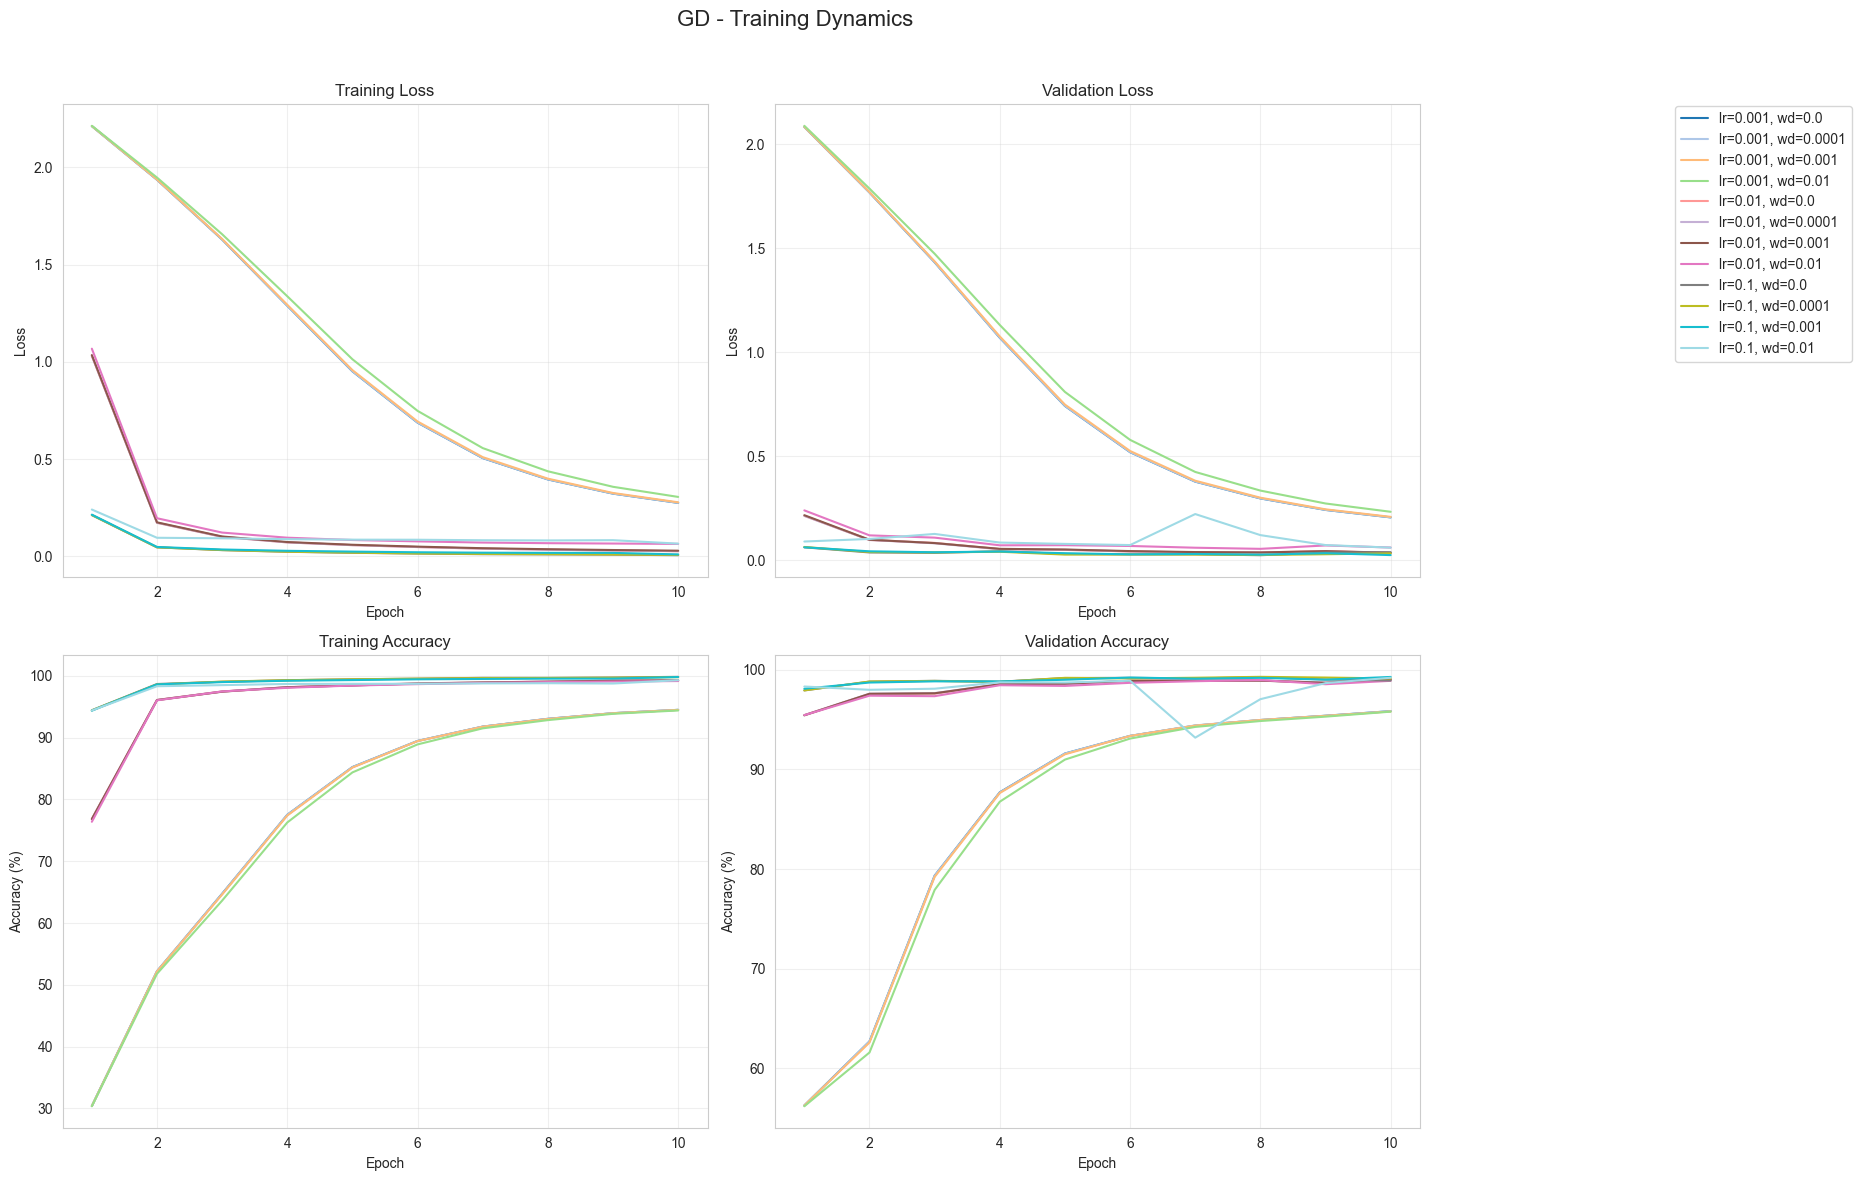

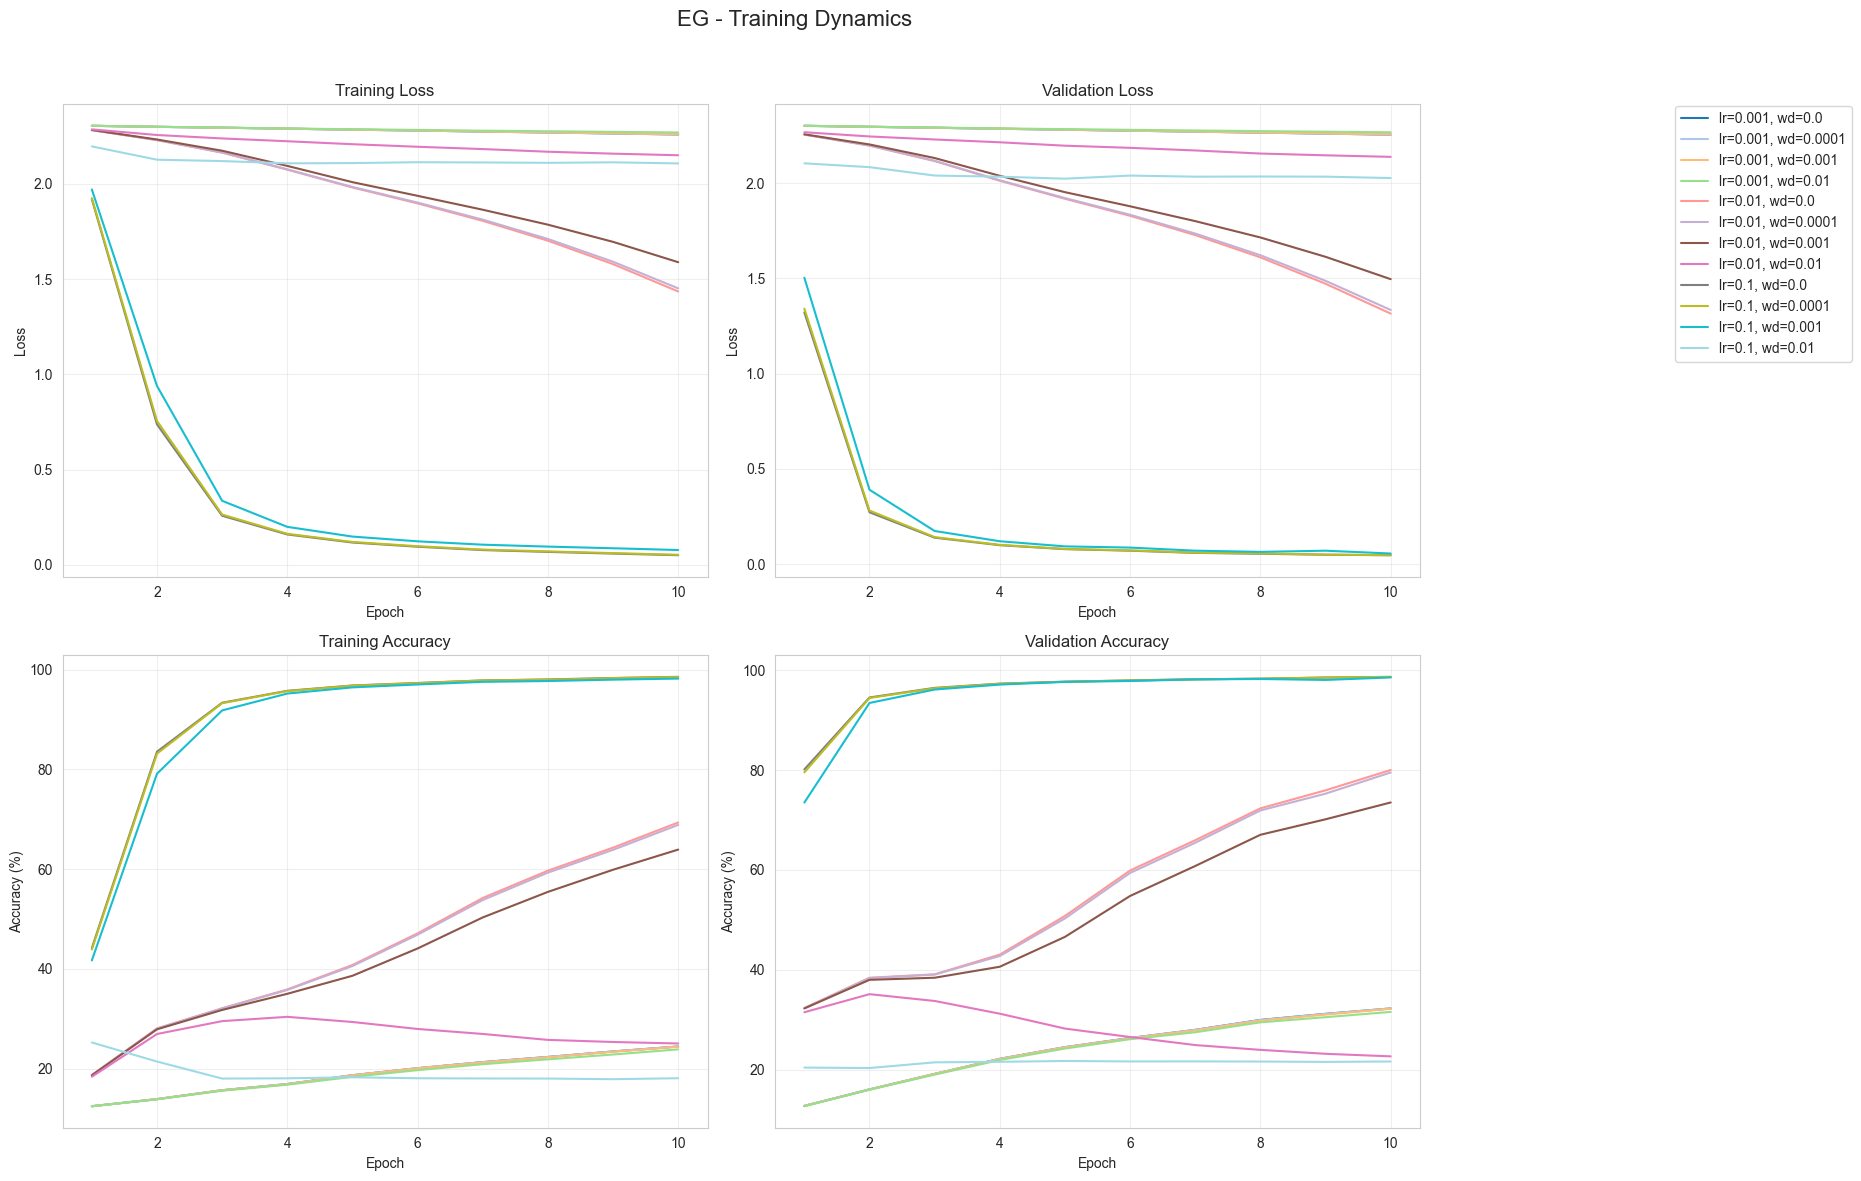

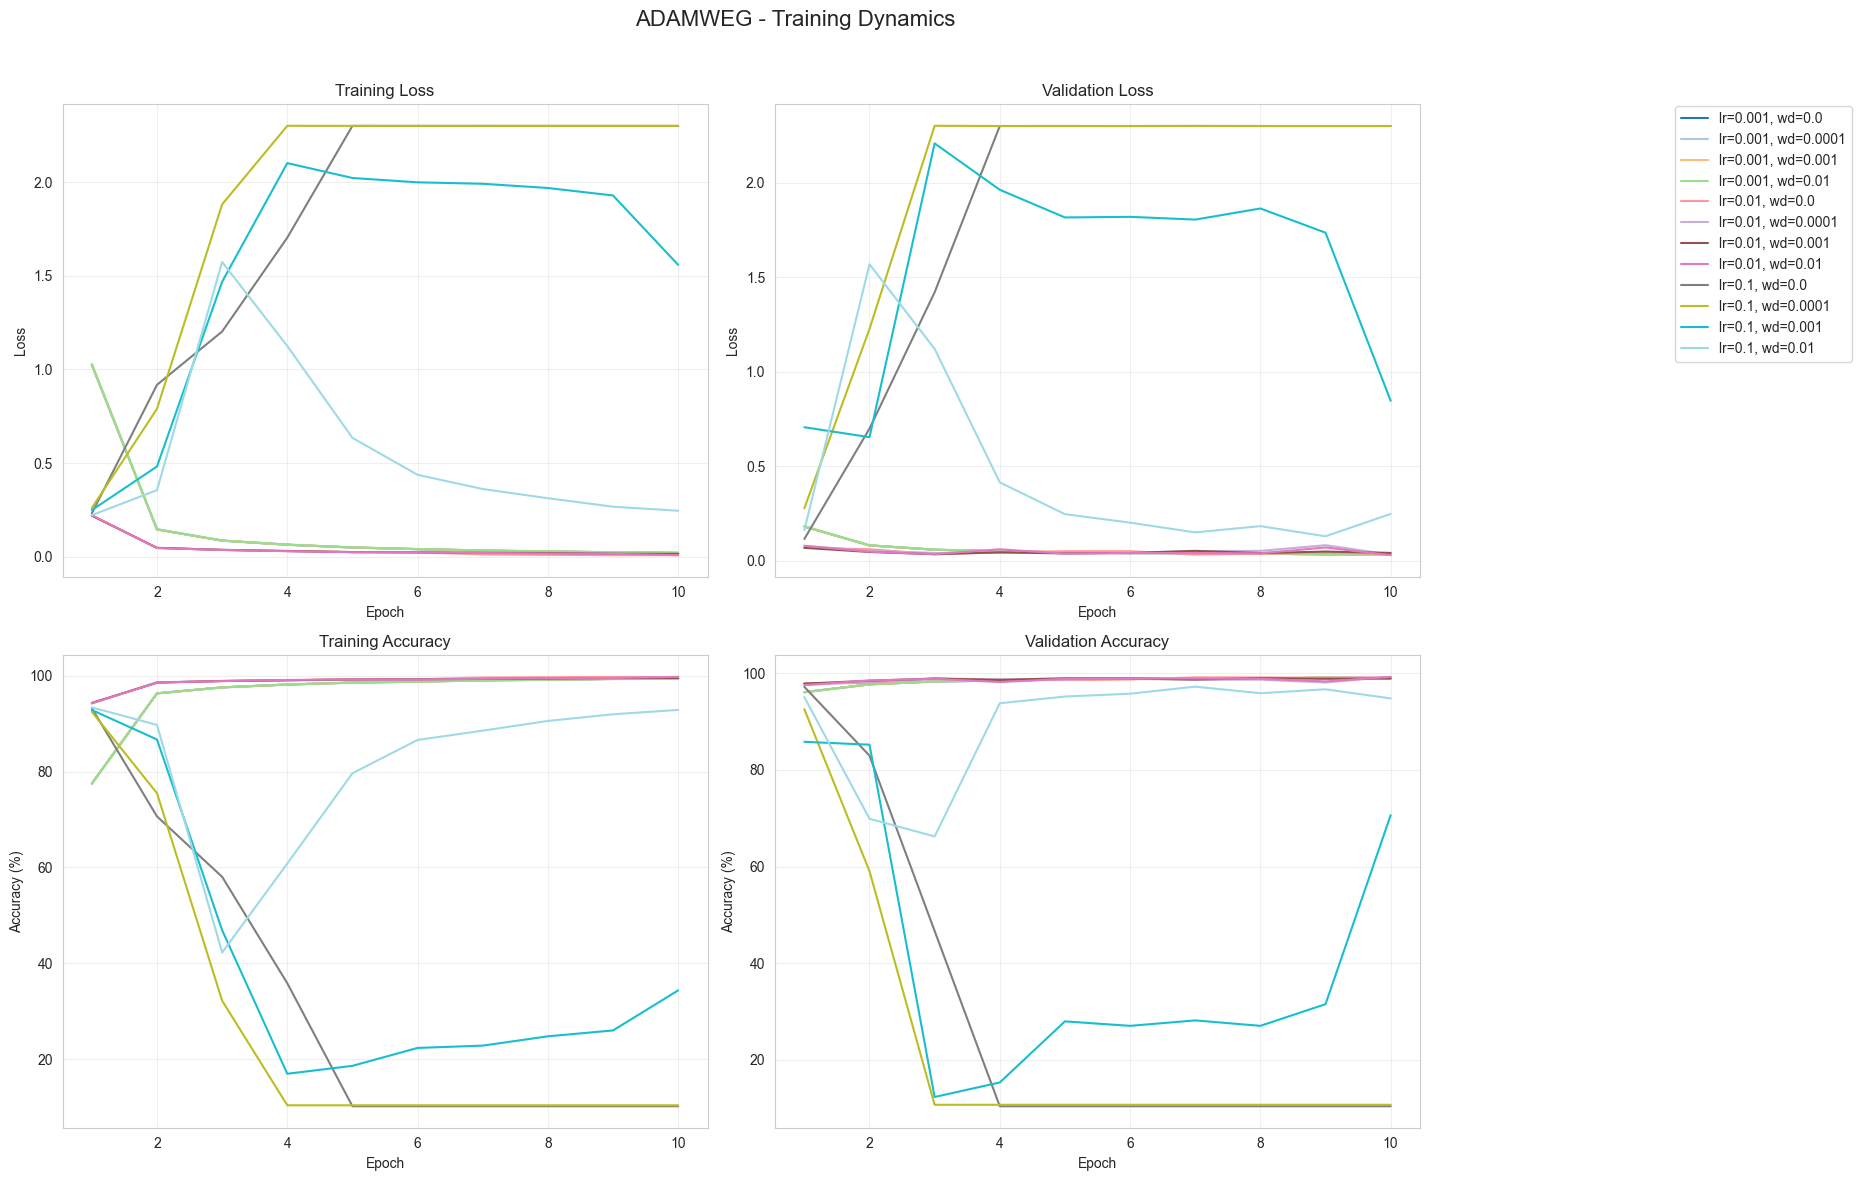

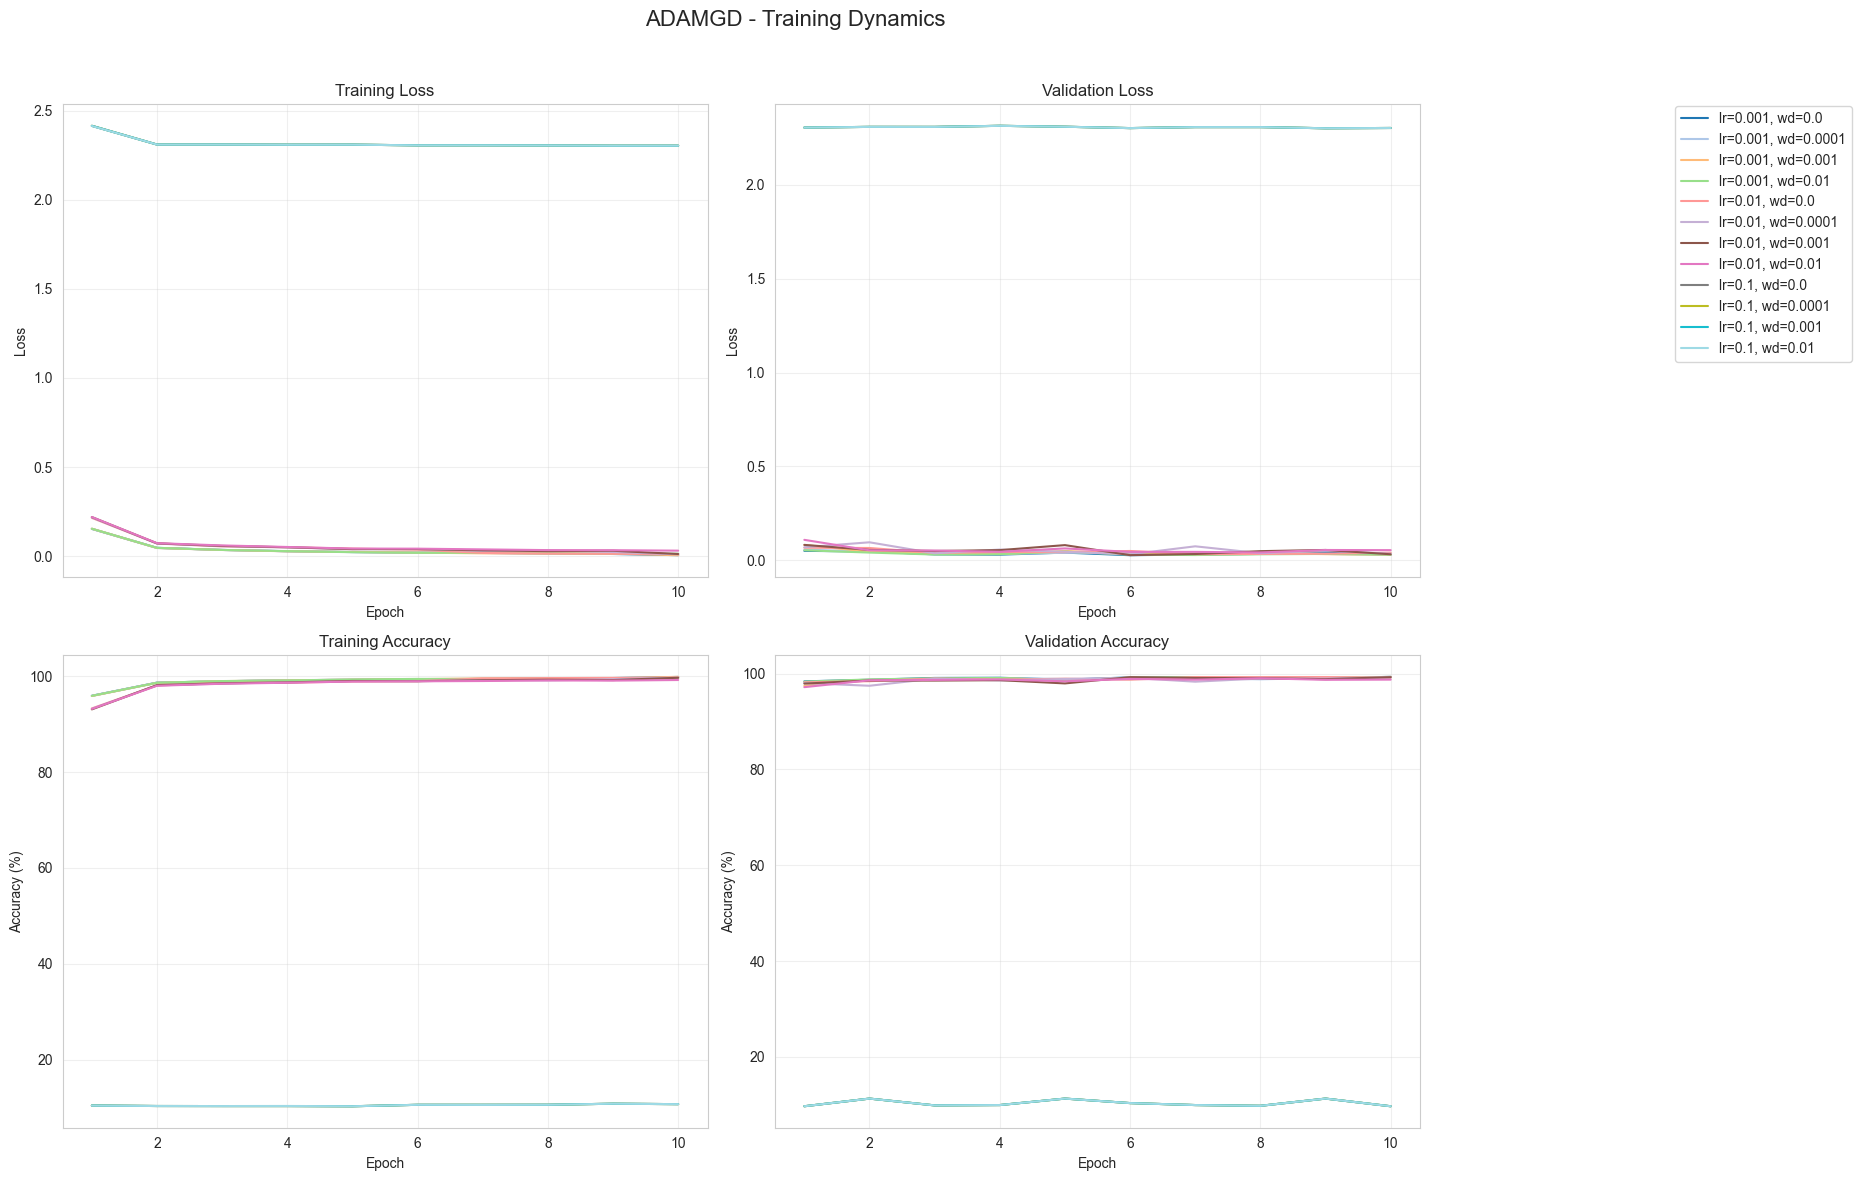

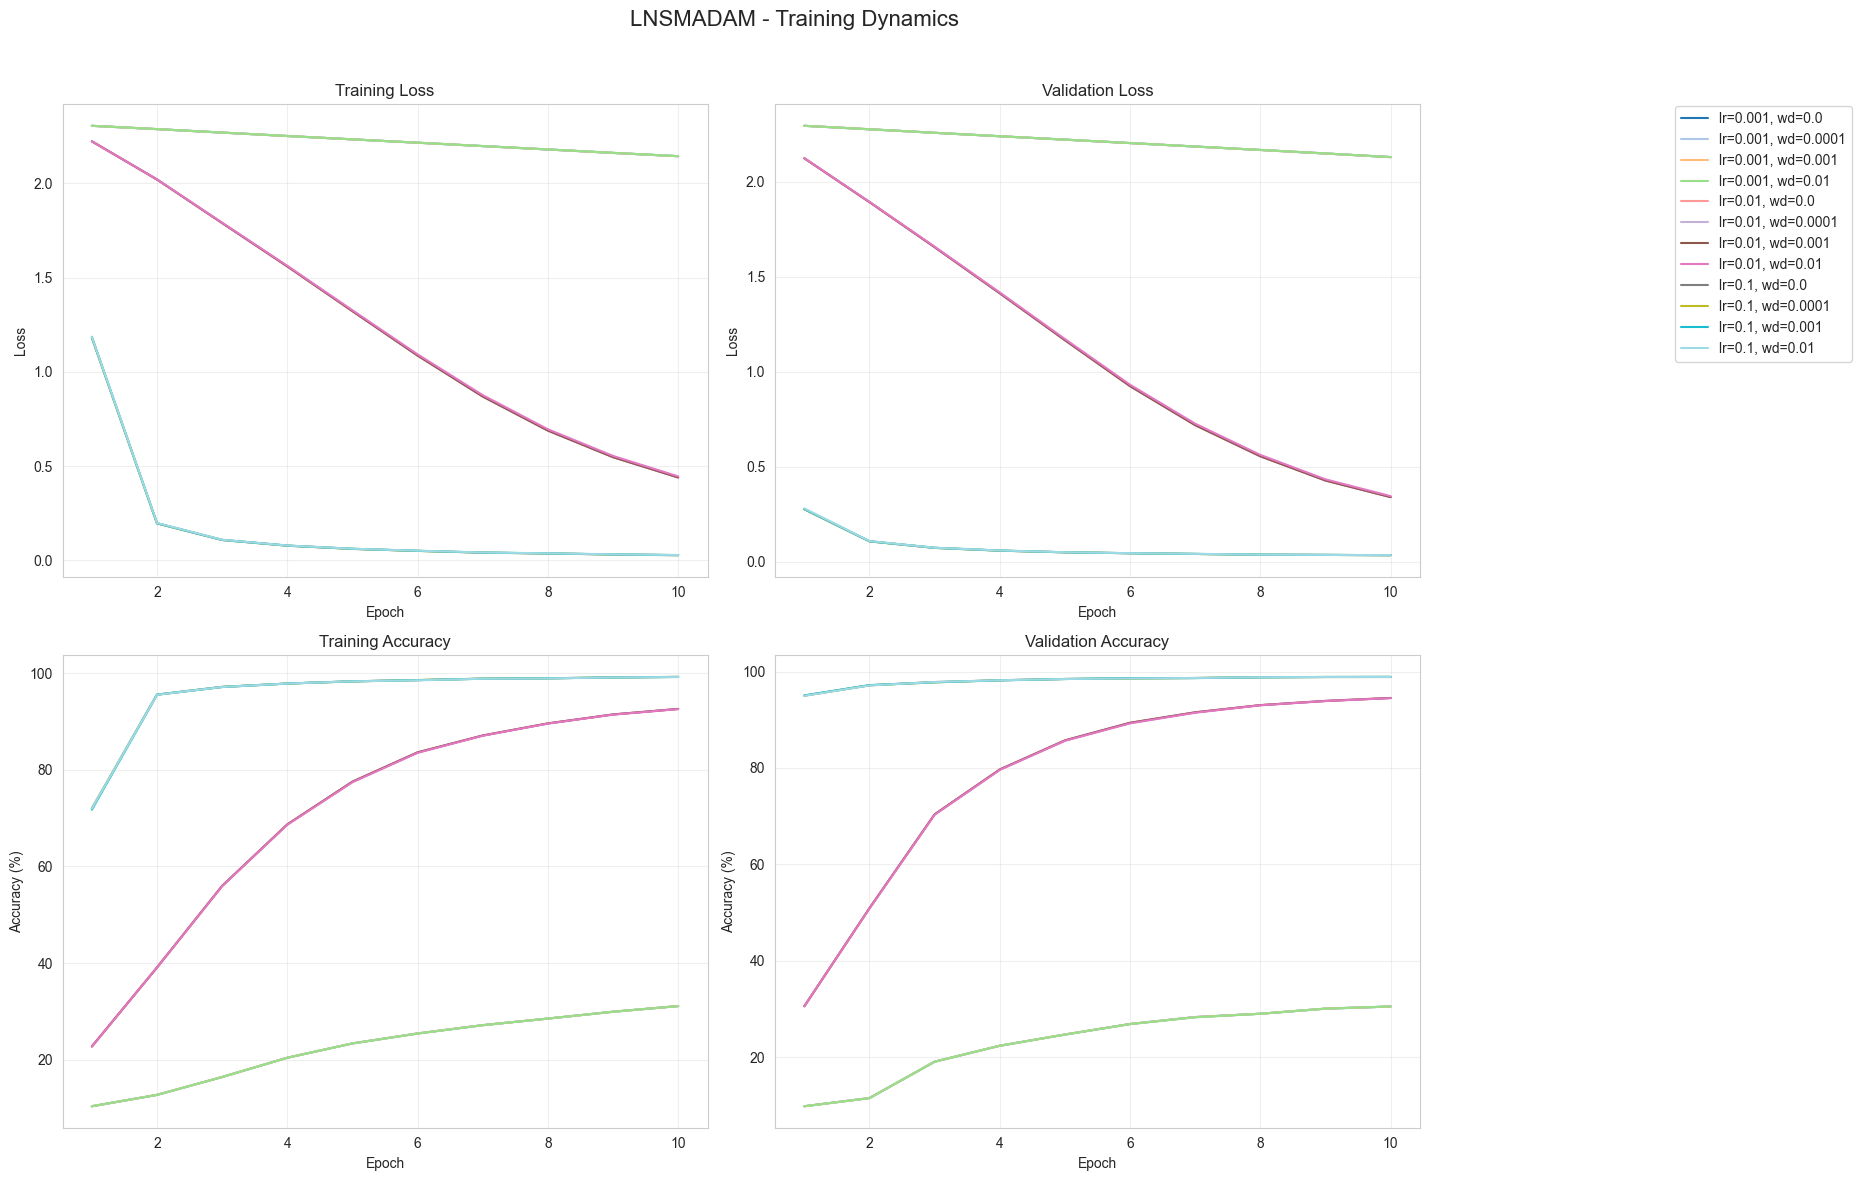

Plots saved in 'analysis_plots/' directory.


In [6]:
# Cell 6: Plot Detailed Training Curves by Optimizer

def plot_training_curves_by_optimizer(curves_df):
    """Plot training curves for each optimizer"""
    optimizers = curves_df['optimizer'].unique()
    
    for optimizer in optimizers:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{optimizer} - Training Dynamics', fontsize=16)
        
        opt_data = curves_df[curves_df['optimizer'] == optimizer]
        unique_configs = opt_data[['lr', 'weight_decay']].drop_duplicates().sort_values(['lr', 'weight_decay'])
        colors = plt.cm.tab20(np.linspace(0, 1, len(unique_configs)))
        
        for i, (_, config) in enumerate(unique_configs.iterrows()):
            lr, wd = config['lr'], config['weight_decay']
            config_data = opt_data[(opt_data['lr'] == lr) & (opt_data['weight_decay'] == wd)].sort_values('epoch')
            label = f'lr={lr}, wd={wd}'
            
            ax1.plot(config_data['epoch'], config_data['train_loss'], color=colors[i], label=label)
            ax2.plot(config_data['epoch'], config_data['val_loss'], color=colors[i], label=label)
            ax3.plot(config_data['epoch'], config_data['train_acc'], color=colors[i], label=label)
            ax4.plot(config_data['epoch'], config_data['val_acc'], color=colors[i], label=label)
            
        ax1.set_title('Training Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
        ax2.set_title('Validation Loss'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
        ax3.set_title('Training Accuracy'); ax3.set_xlabel('Epoch'); ax3.set_ylabel('Accuracy (%)')
        ax4.set_title('Validation Accuracy'); ax4.set_xlabel('Epoch'); ax4.set_ylabel('Accuracy (%)')
        
        for ax in [ax1, ax2, ax3, ax4]: ax.grid(True, alpha=0.3)
        handles, labels = ax4.get_legend_handles_labels()
        fig.legend(handles, labels, bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0.)
        
        plt.tight_layout(rect=[0, 0, 0.9, 0.96])
        plt.savefig(f'analysis_plots/{optimizer}_training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

if 'curves_df' in locals() and not curves_df.empty:
    print("Generating detailed training curve plots for each optimizer...")
    plot_training_curves_by_optimizer(curves_df)
    print("Plots saved in 'analysis_plots/' directory.")


Generating learning rate comparison plots...


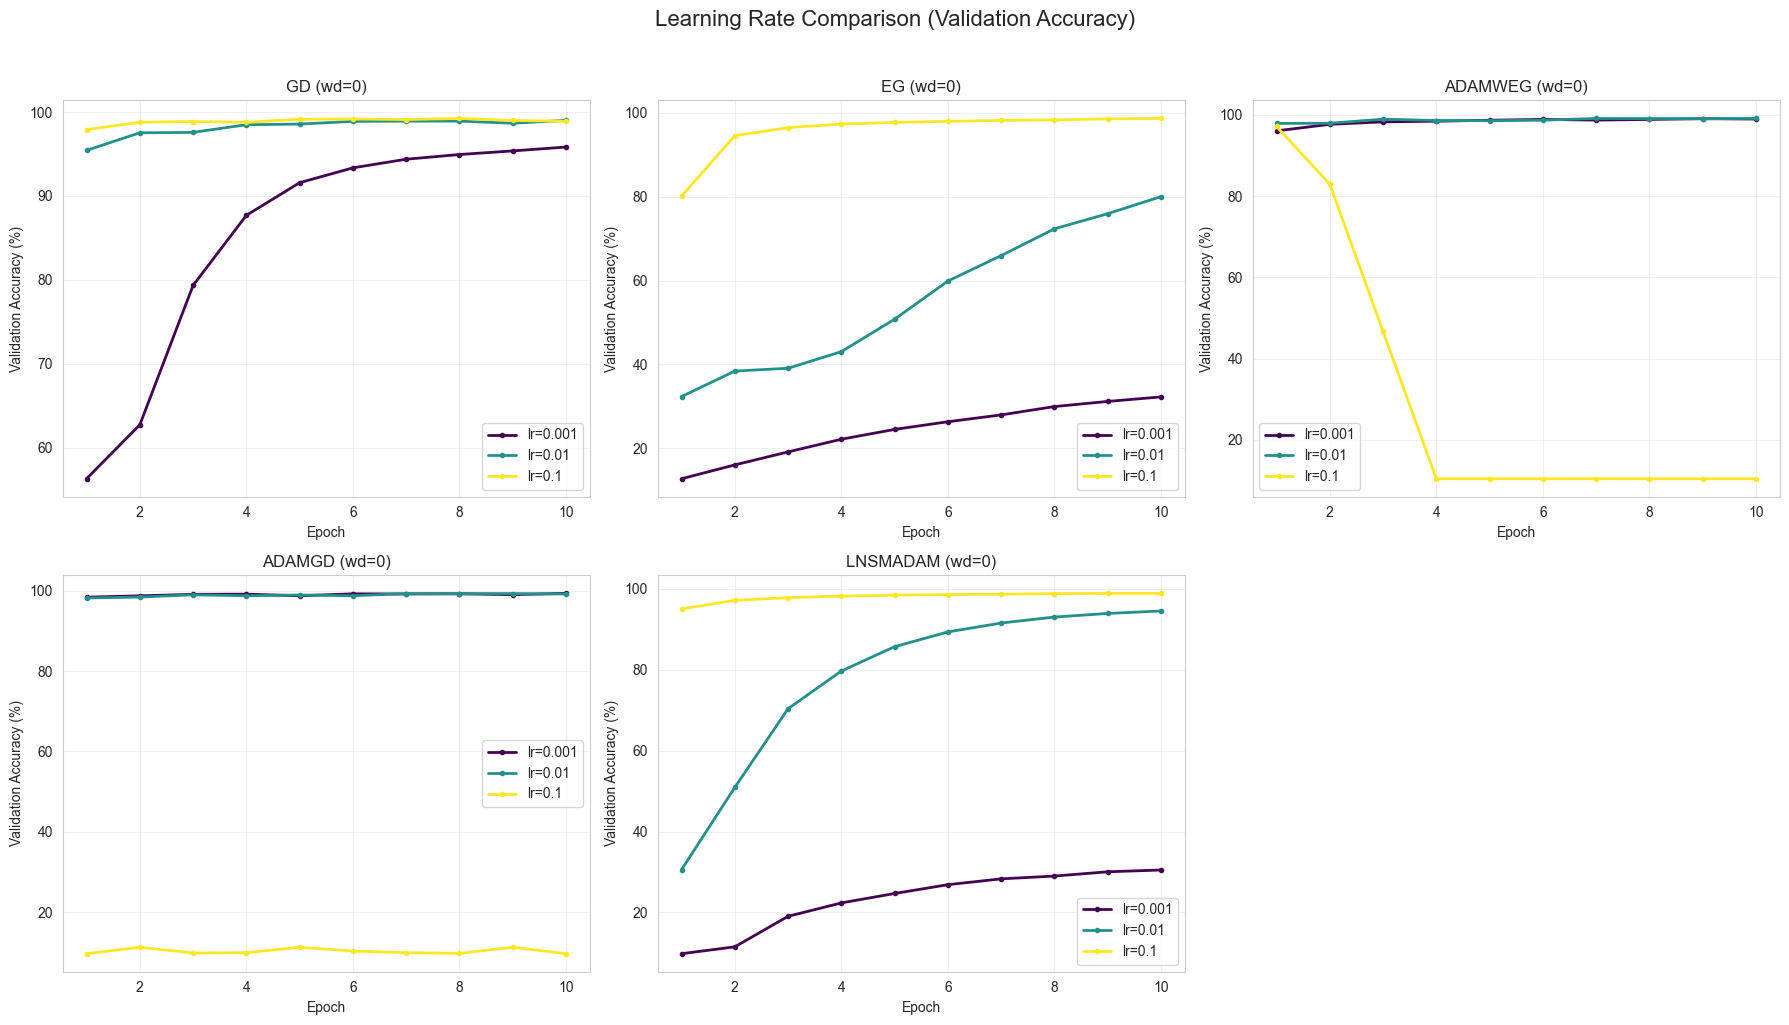

Plot saved as 'analysis_plots/learning_rate_comparison.png'


In [7]:
# Cell 7: Compare Learning Rates

def plot_learning_rate_comparison(curves_df):
    """Compare training effects under different learning rates (at wd=0)"""
    optimizers = curves_df['optimizer'].unique()
    n_optimizers = len(optimizers)
    n_cols = 3
    n_rows = (n_optimizers + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows), squeeze=False)
    axes = axes.flatten()
    
    for i, optimizer in enumerate(optimizers):
        ax = axes[i]
        wd_zero_data = curves_df[(curves_df['optimizer'] == optimizer) & (curves_df['weight_decay'] == 0.0)]
        learning_rates = sorted(wd_zero_data['lr'].unique())
        colors = plt.cm.viridis(np.linspace(0, 1, len(learning_rates)))
        
        for lr, color in zip(learning_rates, colors):
            lr_data = wd_zero_data[wd_zero_data['lr'] == lr]
            ax.plot(lr_data['epoch'], lr_data['val_acc'], color=color, label=f'lr={lr}', marker='o', markersize=3, linewidth=2)
            
        ax.set_title(f'{optimizer} (wd=0)'); ax.set_xlabel('Epoch'); ax.set_ylabel('Validation Accuracy (%)')
        ax.legend(); ax.grid(True, alpha=0.3)
        
    for j in range(n_optimizers, len(axes)): axes[j].set_visible(False)
    fig.suptitle('Learning Rate Comparison (Validation Accuracy)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('analysis_plots/learning_rate_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'curves_df' in locals() and not curves_df.empty:
    print("\nGenerating learning rate comparison plots...")
    plot_learning_rate_comparison(curves_df)
    print("Plot saved as 'analysis_plots/learning_rate_comparison.png'")


Generating weight decay comparison plots...


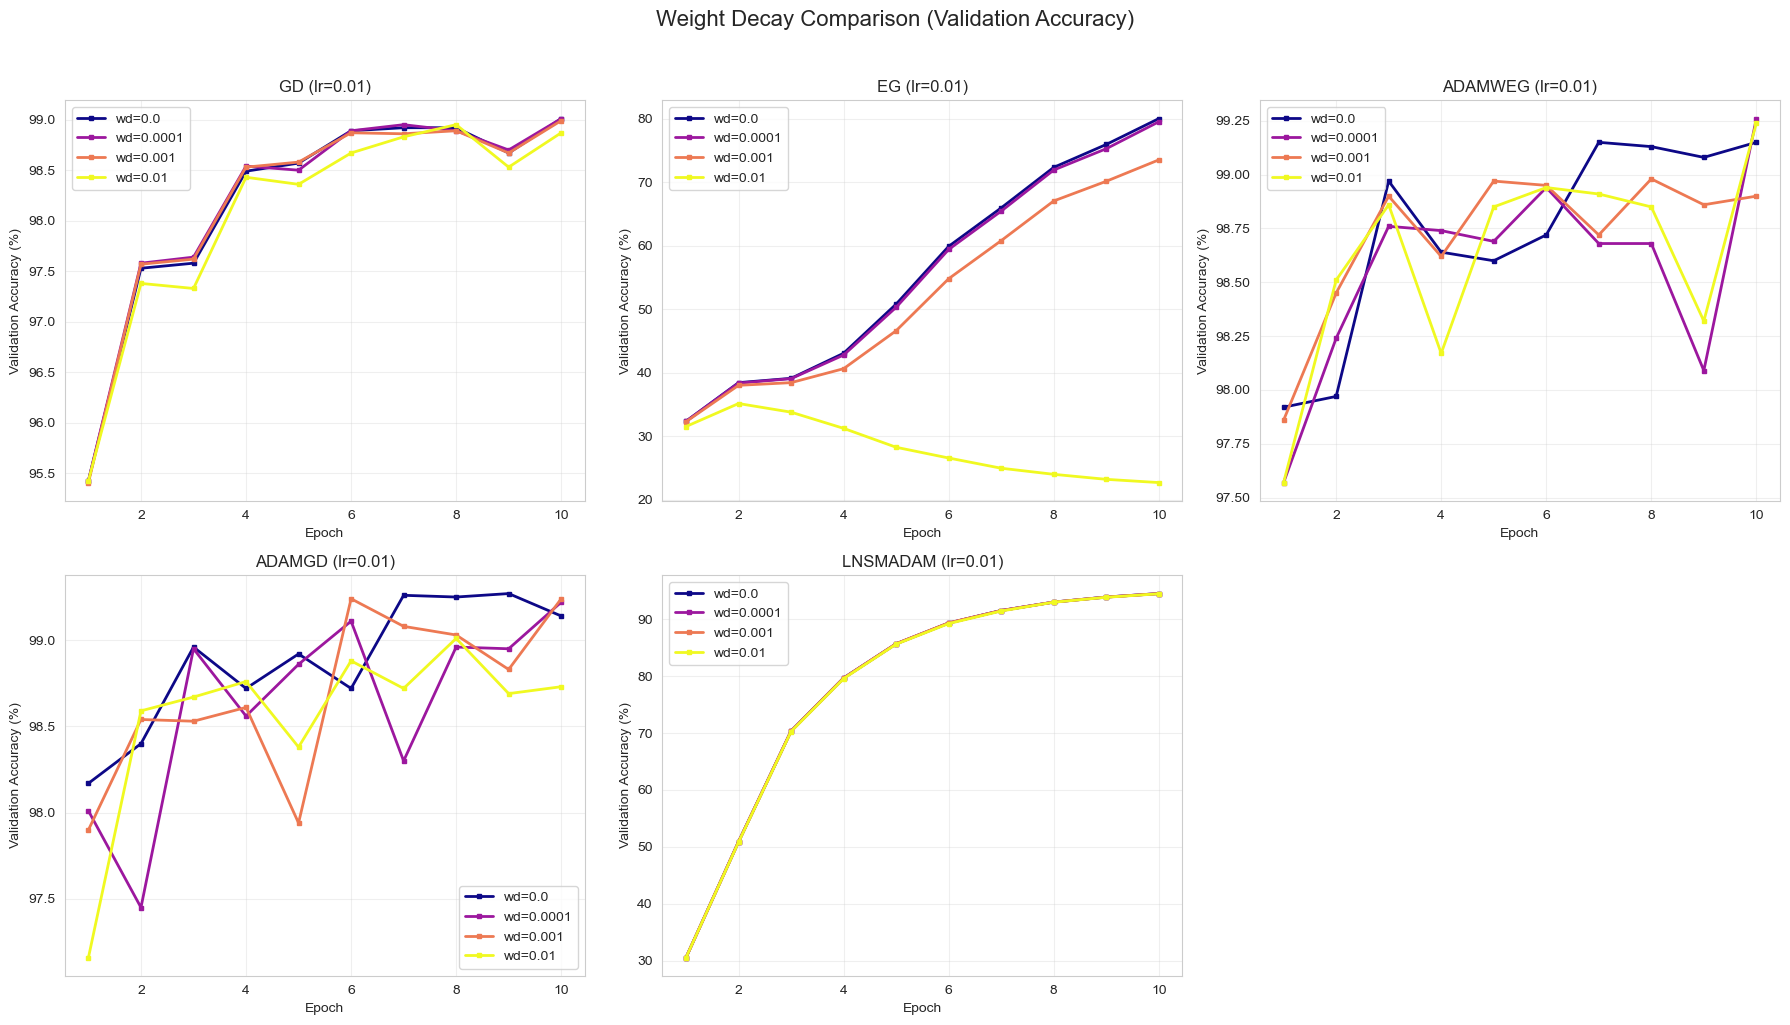

Plot saved as 'analysis_plots/weight_decay_comparison.png'


In [8]:
# Cell 8: Compare Weight Decay Values

def plot_weight_decay_comparison(curves_df):
    """Compare training effects under different weight decay values (at lr=0.01)"""
    optimizers = curves_df['optimizer'].unique()
    n_optimizers = len(optimizers)
    n_cols = 3
    n_rows = (n_optimizers + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows), squeeze=False)
    axes = axes.flatten()
    
    for i, optimizer in enumerate(optimizers):
        ax = axes[i]
        lr_fixed_data = curves_df[(curves_df['optimizer'] == optimizer) & (curves_df['lr'] == 0.01)]
        
        if lr_fixed_data.empty:
            ax.text(0.5, 0.5, 'No data for lr=0.01', ha='center', va='center', transform=ax.transAxes)
        else:
            weight_decays = sorted(lr_fixed_data['weight_decay'].unique())
            colors = plt.cm.plasma(np.linspace(0, 1, len(weight_decays)))
            for wd, color in zip(weight_decays, colors):
                wd_data = lr_fixed_data[lr_fixed_data['weight_decay'] == wd]
                ax.plot(wd_data['epoch'], wd_data['val_acc'], color=color, label=f'wd={wd}', marker='s', markersize=3, linewidth=2)
            ax.legend()
            
        ax.set_title(f'{optimizer} (lr=0.01)'); ax.set_xlabel('Epoch'); ax.set_ylabel('Validation Accuracy (%)'); ax.grid(True, alpha=0.3)

    for j in range(n_optimizers, len(axes)): axes[j].set_visible(False)
    fig.suptitle('Weight Decay Comparison (Validation Accuracy)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('analysis_plots/weight_decay_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if 'curves_df' in locals() and not curves_df.empty:
    print("\nGenerating weight decay comparison plots...")
    plot_weight_decay_comparison(curves_df)
    print("Plot saved as 'analysis_plots/weight_decay_comparison.png'")


Generating final optimizer comparison plot...


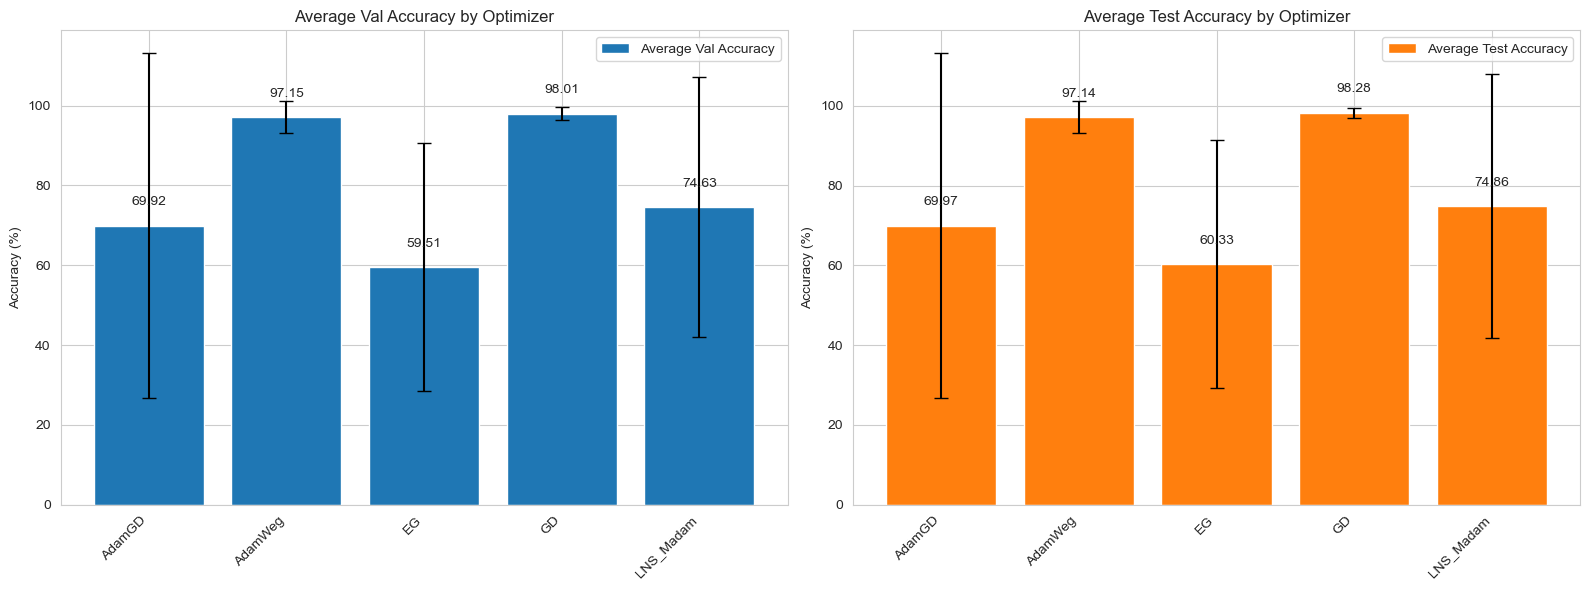

Plot saved as 'analysis_plots/optimizer_comparison.png'

Average Performance:
optimizer  val_acc_mean  val_acc_std  test_acc_mean  test_acc_std
   AdamGD     69.925000    43.282726      69.972500     43.295660
  AdamWeg     97.146667     4.054807      97.142500      4.055546
       EG     59.507500    31.090100      60.333333     31.194771
       GD     98.012500     1.630327      98.281667      1.248059
LNS_Madam     74.629167    32.657680      74.857500     33.044872


In [9]:
# Cell 9: Compare Overall Optimizer Performance

def plot_comparison_bar(df):
    """Create optimizer comparison bar chart of average performance"""
    avg_performance = df.groupby('optimizer').agg(
        val_acc_mean=('val_acc', 'mean'), val_acc_std=('val_acc', 'std'),
        test_acc_mean=('test_acc', 'mean'), test_acc_std=('test_acc', 'std')
    ).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    x = np.arange(len(avg_performance))
    
    for ax, metric, color in [(ax1, 'val', 'C0'), (ax2, 'test', 'C1')]:
        means = avg_performance[f'{metric}_acc_mean']
        stds = avg_performance[f'{metric}_acc_std']
        bars = ax.bar(x, means, yerr=stds, capsize=5, color=color, label=f'Average {metric.capitalize()} Accuracy')
        ax.set_ylabel('Accuracy (%)')
        ax.set_title(f'Average {metric.capitalize()} Accuracy by Optimizer')
        ax.set_xticks(x)
        ax.set_xticklabels(avg_performance['optimizer'], rotation=45, ha="right")
        ax.legend()
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.0, yval + (stds.max()*0.1), f'{yval:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('analysis_plots/optimizer_comparison.png', dpi=300)
    plt.show()
    return avg_performance

if 'results_df' in locals() and not results_df.empty:
    print("\nGenerating final optimizer comparison plot...")
    avg_perf_df = plot_comparison_bar(results_df)
    print("Plot saved as 'analysis_plots/optimizer_comparison.png'")
    print("\nAverage Performance:")
    print(avg_perf_df.to_string(index=False))

In [ ]:
# Cell 10: Find and Save Best Configurations

def find_best_configurations(df):
    """Find and tabulate the best configuration for each optimizer based on test accuracy"""
    print("\n" + "="*80)
    print("BEST CONFIGURATIONS FOR EACH OPTIMIZER (based on max Test Accuracy)")
    print("="*80)
    
    # Use idxmax to find the index of the max test_acc for each group
    best_idx = df.groupby('optimizer')['test_acc'].idxmax()
    best_configs_df = df.loc[best_idx].sort_values(by='test_acc', ascending=False)
    best_configs_df = best_configs_df[['optimizer', 'lr', 'weight_decay', 'val_acc', 'test_acc']]
    
    print(best_configs_df.to_string(index=False))
    return best_configs_df

if 'results_df' in locals() and not results_df.empty:
    best_configs = find_best_configurations(results_df)
    best_configs.to_csv('best_configurations.csv', index=False)
    print("\n\n✅ Best configurations saved to best_configurations.csv")
    print("Analysis complete!")

In [1]:
# Cell 1: Setup for Quantization Analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Create quantization plots directory
plots_dir = 'quantization_plots'
os.makedirs(plots_dir, exist_ok=True)

# Set plot style
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

# Helper functions for data parsing
def parse_percentage(val):
    """Convert percentage string to float"""
    return float(val.replace('%', ''))

def parse_size(val):
    """Convert size string to float"""
    return float(val)

def parse_compression(val):
    """Convert compression ratio string to float"""
    return float(val.replace('x', ''))

# Read quantization results
df = pd.read_csv('quantization_results.csv')

# Parse data
df['FP32_Acc'] = df['FP32_Accuracy'].apply(parse_percentage)
df['INT8_Acc'] = df['INT8_Accuracy'].apply(parse_percentage)
df['Acc_Loss'] = df['Accuracy_Loss'].apply(parse_percentage)
df['FP32_Size'] = df['FP32_Size_MB'].apply(parse_size)
df['INT8_Size'] = df['INT8_Size_MB'].apply(parse_size)
df['Compression'] = df['Compression_Ratio'].apply(parse_compression)

print("Quantization data loaded successfully!")
print(f"Shape: {df.shape}")
df.head()


Quantization data loaded successfully!
Shape: (4, 17)


,Optimizer,Learning_Rate,Weight_Decay,Original_Val_Acc,Original_Test_Acc,FP32_Accuracy,INT8_Accuracy,Accuracy_Loss,FP32_Size_MB,INT8_Size_MB,Compression_Ratio,FP32_Acc,INT8_Acc,Acc_Loss,FP32_Size,INT8_Size,Compression
0,GD,0.100,0.0000,99.24%,99.28%,99.28%,99.32%,-0.04%,1.63,0.41,3.94x,99.28,99.32,-0.04,1.63,0.41,3.94
1,EG,0.100,0.0001,98.66%,98.81%,98.81%,98.77%,0.04%,1.63,0.41,3.94x,98.81,98.77,0.04,1.63,0.41,3.94
2,AdamWeg,0.010,0.0100,99.24%,99.27%,99.27%,99.28%,-0.01%,4.87,0.41,11.78x,99.27,99.28,-0.01,4.87,0.41,11.78
3,AdamGD,0.001,0.0010,99.30%,99.40%,99.40%,99.42%,-0.02%,4.87,0.41,11.78x,99.40,99.42,-0.02,4.87,0.41,11.78


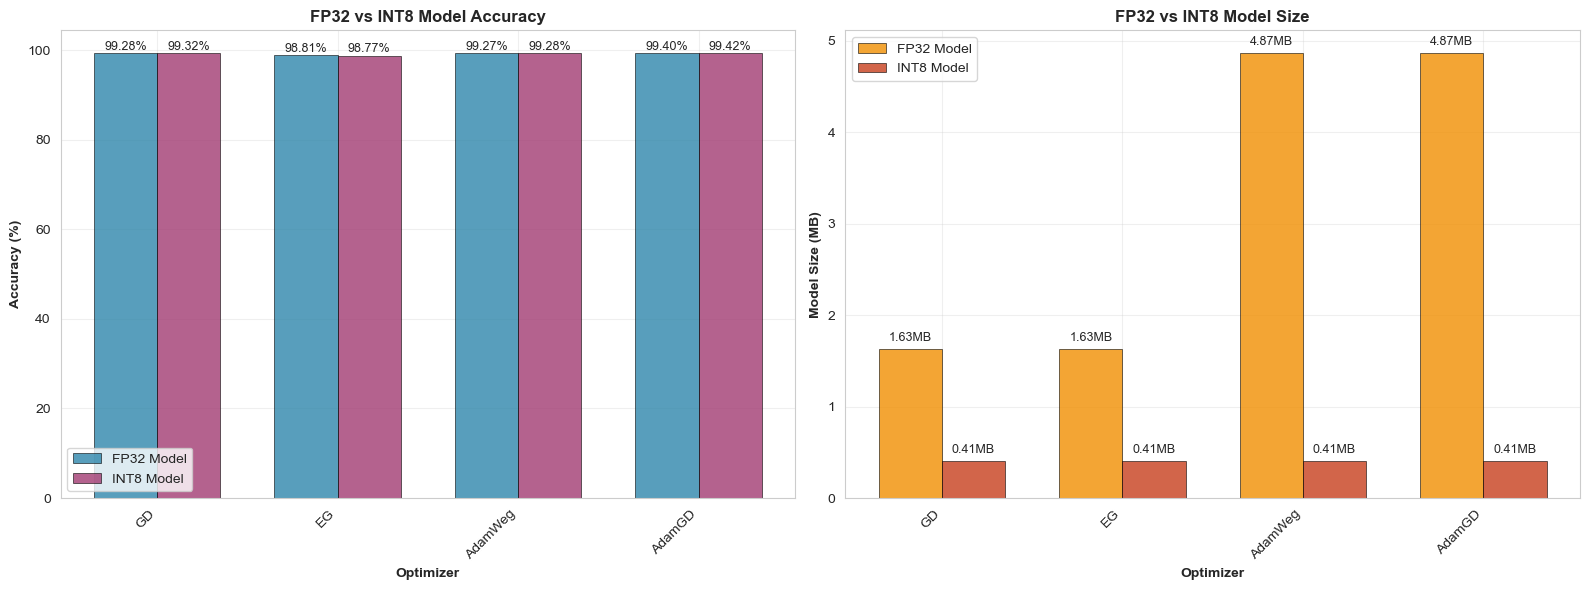

In [2]:
# Cell 2: Accuracy and Model Size Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy comparison
x = np.arange(len(df))
width = 0.35

bars1 = ax1.bar(x - width/2, df['FP32_Acc'], width, label='FP32 Model', 
                color='#2E86AB', alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = ax1.bar(x + width/2, df['INT8_Acc'], width, label='INT8 Model', 
                color='#A23B72', alpha=0.8, edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Optimizer', fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontweight='bold')
ax1.set_title('FP32 vs INT8 Model Accuracy', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df['Optimizer'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

# 2. Model size comparison
bars3 = ax2.bar(x - width/2, df['FP32_Size'], width, label='FP32 Model', 
                color='#F18F01', alpha=0.8, edgecolor='black', linewidth=0.5)
bars4 = ax2.bar(x + width/2, df['INT8_Size'], width, label='INT8 Model', 
                color='#C73E1D', alpha=0.8, edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Optimizer', fontweight='bold')
ax2.set_ylabel('Model Size (MB)', fontweight='bold')
ax2.set_title('FP32 vs INT8 Model Size', fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df['Optimizer'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}MB', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}MB', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'accuracy_size_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


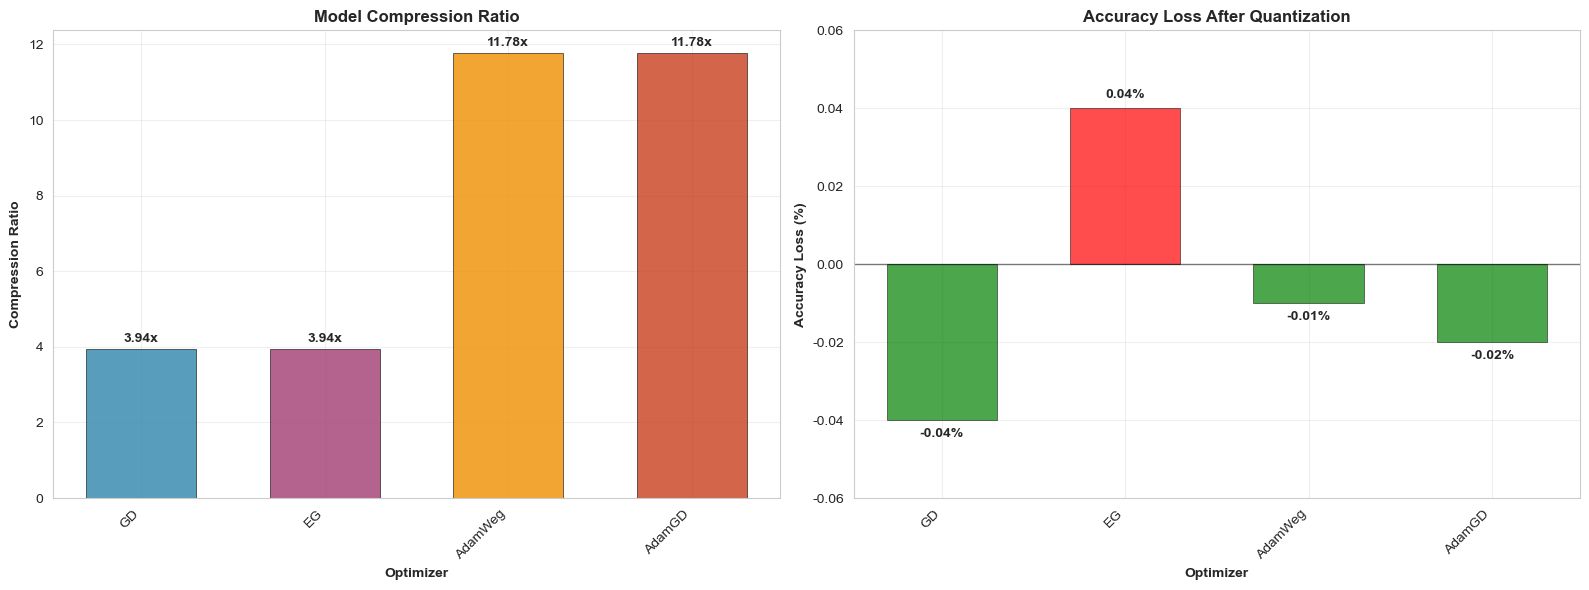

In [3]:
# Cell 3: Compression Ratio and Accuracy Loss Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Compression ratio
bars1 = ax1.bar(df['Optimizer'], df['Compression'], 
                color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'], 
                alpha=0.8, edgecolor='black', linewidth=0.5, width=0.6)

ax1.set_xlabel('Optimizer', fontweight='bold')
ax1.set_ylabel('Compression Ratio', fontweight='bold')
ax1.set_title('Model Compression Ratio', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
plt.setp(ax1.get_xticklabels(), ha='right')
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Accuracy loss
colors = ['green' if x <= 0 else 'red' for x in df['Acc_Loss']]
bars2 = ax2.bar(df['Optimizer'], df['Acc_Loss'], 
                color=colors, alpha=0.7, edgecolor='black', linewidth=0.5, width=0.6)

ax2.set_xlabel('Optimizer', fontweight='bold')
ax2.set_ylabel('Accuracy Loss (%)', fontweight='bold')
ax2.set_title('Accuracy Loss After Quantization', fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
plt.setp(ax2.get_xticklabels(), ha='right')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
ax2.grid(True, alpha=0.3)

# Set y-axis range to better show small values
y_min = min(df['Acc_Loss']) - 0.02
y_max = max(df['Acc_Loss']) + 0.02
ax2.set_ylim(y_min, y_max)

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    # For very small values, adjust label position
    if abs(height) < 0.01:
        if height >= 0:
            y_pos = height + 0.005
            va = 'bottom'
        else:
            y_pos = height - 0.005
            va = 'top'
    else:
        if height >= 0:
            y_pos = height + 0.002
            va = 'bottom'
        else:
            y_pos = height - 0.002
            va = 'top'
    
    ax2.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{height:.2f}%', ha='center', va=va, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'compression_accuracy_loss.png'), dpi=300, bbox_inches='tight')
plt.show()


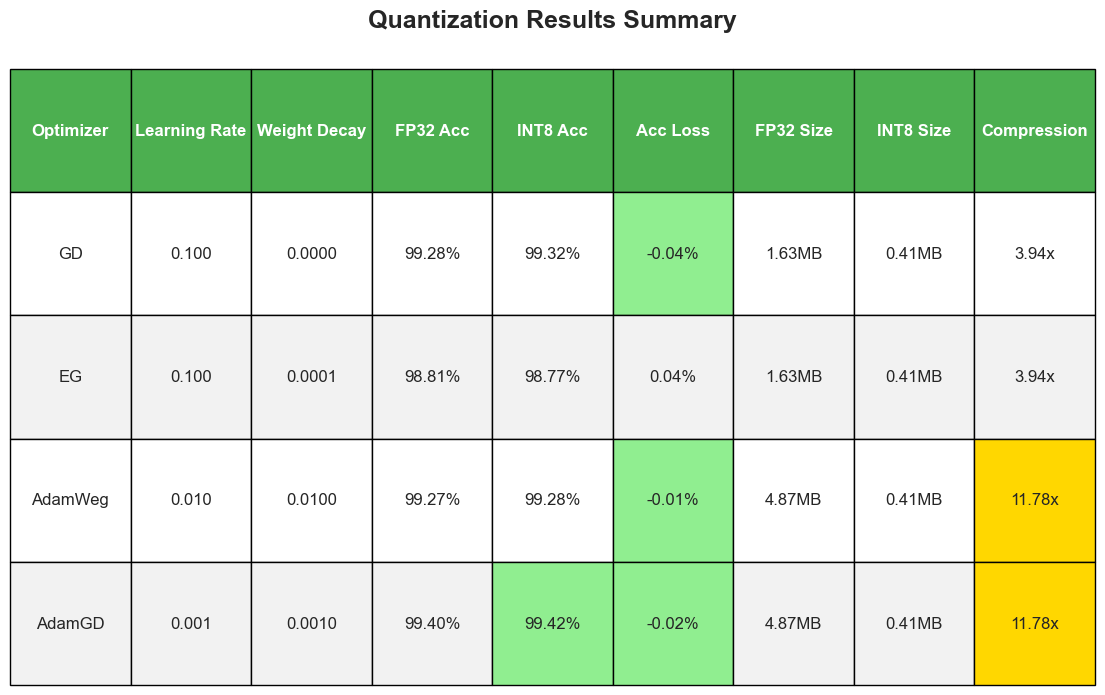


QUANTIZATION ANALYSIS SUMMARY
Best INT8 Accuracy: 99.42% (AdamGD)
Best Compression Ratio: 11.78x (AdamWeg)
Average Accuracy Loss: -0.007%
Average Compression Ratio: 7.86x
Average Size Reduction: 83.2%

Models with accuracy improvement after quantization:
- GD: 0.04% improvement
- AdamWeg: 0.01% improvement
- AdamGD: 0.02% improvement


In [4]:
# Cell 4: Quantization Summary Table
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
for _, row in df.iterrows():
    table_data.append([
        row['Optimizer'],
        f"{row['Learning_Rate']:.3f}",
        f"{row['Weight_Decay']:.4f}",
        f"{row['FP32_Acc']:.2f}%",
        f"{row['INT8_Acc']:.2f}%",
        f"{row['Acc_Loss']:.2f}%",
        f"{row['FP32_Size']:.2f}MB",
        f"{row['INT8_Size']:.2f}MB",
        f"{row['Compression']:.2f}x"
    ])

# Create table
table = ax.table(cellText=table_data,
                colLabels=['Optimizer', 'Learning Rate', 'Weight Decay', 'FP32 Acc', 'INT8 Acc', 
                          'Acc Loss', 'FP32 Size', 'INT8 Size', 'Compression'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

# Set table style
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2.5)

# Set header style
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Set alternating row colors
for i in range(1, len(table_data) + 1):
    for j in range(len(table_data[0])):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f2f2f2')
        else:
            table[(i, j)].set_facecolor('white')

# Highlight best performance cells
for i in range(1, len(table_data) + 1):
    # Highlight best accuracy (INT8)
    if df.iloc[i-1]['INT8_Acc'] == df['INT8_Acc'].max():
        table[(i, 4)].set_facecolor('#90EE90')  # Light green
    
    # Highlight best compression ratio
    if df.iloc[i-1]['Compression'] == df['Compression'].max():
        table[(i, 8)].set_facecolor('#FFD700')  # Gold
    
    # Highlight negative accuracy loss (improvement)
    if df.iloc[i-1]['Acc_Loss'] < 0:
        table[(i, 5)].set_facecolor('#90EE90')  # Light green

plt.title('Quantization Results Summary', fontsize=18, fontweight='bold', pad=30)
plt.savefig(os.path.join(plots_dir, 'quantization_summary_table.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print key insights
print("\n" + "="*80)
print("QUANTIZATION ANALYSIS SUMMARY")
print("="*80)
print(f"Best INT8 Accuracy: {df['INT8_Acc'].max():.2f}% ({df.loc[df['INT8_Acc'].idxmax(), 'Optimizer']})")
print(f"Best Compression Ratio: {df['Compression'].max():.2f}x ({df.loc[df['Compression'].idxmax(), 'Optimizer']})")
print(f"Average Accuracy Loss: {df['Acc_Loss'].mean():.3f}%")
print(f"Average Compression Ratio: {df['Compression'].mean():.2f}x")
print(f"Average Size Reduction: {((df['FP32_Size'] - df['INT8_Size']) / df['FP32_Size'] * 100).mean():.1f}%")

# Models with accuracy improvement
improved_models = df[df['Acc_Loss'] < 0]
if len(improved_models) > 0:
    print(f"\nModels with accuracy improvement after quantization:")
    for _, row in improved_models.iterrows():
        print(f"- {row['Optimizer']}: {abs(row['Acc_Loss']):.2f}% improvement")
else:
    print("\nNo models showed accuracy improvement after quantization.")
